# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from tqdm.autonotebook import tqdm

import amp_research.price_movement_analysis as pma
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as pri
import helpers.s3 as hs3
import vendors.cme.read as cmer
import vendors.kibot.utils as kut

/wd/julia/.conda/envs/p1_develop/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
def get_top_100(series):
    return series.sort_values(ascending=False).head(100)

In [4]:
print(env.get_system_signature())

pri.config_notebook()

dbg.init_logger(verb=logging.INFO)

_LOG = logging.getLogger(__name__)

# Packages
         python: 3.7.3
         joblib: 0.14.0
          numpy: 1.17.2
         pandas: 0.25.1
        pyarrow: 0.15.0
          scipy: 1.3.1
        seaborn: 0.9.0
        sklearn: 0.21.3
    statsmodels: 0.10.1
# Last commits:
  * 26a8985 Julia    PartTask218 make sns.set() optional                               (  15 hours ago) Mon Oct 14 23:25:50 2019  (HEAD -> PartTask218_PRICE_Large_price_movement_analysis, origin/PartTask218_PRICE_Large_price_movement_analysis)
  * fb2e379 Julia    PartTask218 move files to amp_research                            (  15 hours ago) Mon Oct 14 23:25:03 2019           
  * dbba1cf Julia    PartTask218 Use s3 backend, update for the new price_movement_analysis functions (  15 hours ago) Mon Oct 14 23:22:02 2019           


In [5]:
SYMBOL = 'CL'

# Load daily and minutely data

In [6]:
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_daily/%s.csv.gz"
)
file_name = kibot_path % SYMBOL

daily_prices = kut.read_data(
    file_name, nrows=None
)

daily_prices.tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/CL.csv.gz',) kwargs={'nrows': None}


,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


In [7]:
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_1min/%s.csv.gz"
)
file_name = kibot_path % SYMBOL
minutely_prices = kut.read_data(
    file_name, nrows=None
)

minutely_prices.tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/CL.csv.gz',) kwargs={'nrows': None}


,open,high,low,close,vol,time
datetime,,,,,,
2019-07-19 16:58:00,55.89,55.93,55.88,55.92,49,16:58:00
2019-07-19 16:59:00,55.91,55.92,55.86,55.86,131,16:59:00


In [8]:
five_min_prices = minutely_prices.resample("5Min").last()

In [9]:
five_min_prices.head()

,open,high,low,close,vol,time
datetime,,,,,,
2009-09-27 18:00:00,66.39,66.46,66.39,66.46,14.0,18:04:00
2009-09-27 18:05:00,66.39,66.39,66.37,66.38,4.0,18:09:00
2009-09-27 18:10:00,66.37,66.39,66.37,66.39,5.0,18:14:00
2009-09-27 18:15:00,66.41,66.41,66.38,66.38,6.0,18:19:00
2009-09-27 18:20:00,66.32,66.32,66.30,66.30,5.0,18:24:00


# Daily price movements

In [10]:
zscored_rets = pma.get_zscored_returns(
    daily_prices, "daily"
)
top_daily_movements = get_top_100(zscored_rets)

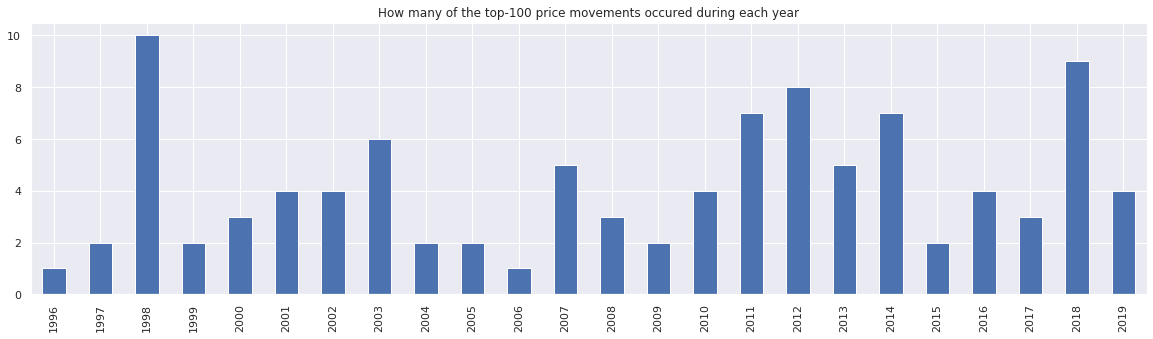

In [11]:
top_daily_movements.index.year.value_counts(sort=False).plot(kind="bar")
plt.title("How many of the top-100 price movements occured during each year")
plt.show()

In [12]:
top_daily_movements_by_year = zscored_rets.resample('Y').apply(get_top_100)
top_daily_movements_by_year.head()

date        date      
1996-12-31  1996-11-18    2.952996
            1996-09-03    2.141749
            1996-09-17    1.933235
            1996-12-12    1.865632
            1996-09-16    1.716851
Name: ret_0, dtype: float64

In [13]:
top_daily_movements_by_year.tail()

date        date      
2019-12-31  2019-04-11    0.298249
            2019-01-28    0.285462
            2019-01-08    0.283900
            2019-06-17    0.278893
            2019-04-22    0.278580
Name: ret_0, dtype: float64

# 1-min movements

In [14]:
zscored_1min_rets = pma.get_zscored_returns(
    minutely_prices, "minutely"
)
top_1min_movements = get_top_100(zscored_1min_rets)

In [15]:
top_1min_movements.head()

datetime
2011-02-17 01:16:00    4.300486
2015-12-16 18:00:00    4.300040
2014-08-17 18:00:00    4.299188
2016-03-16 18:00:00    4.298413
2017-01-17 19:19:00    4.298211
Name: ret_0, dtype: float64

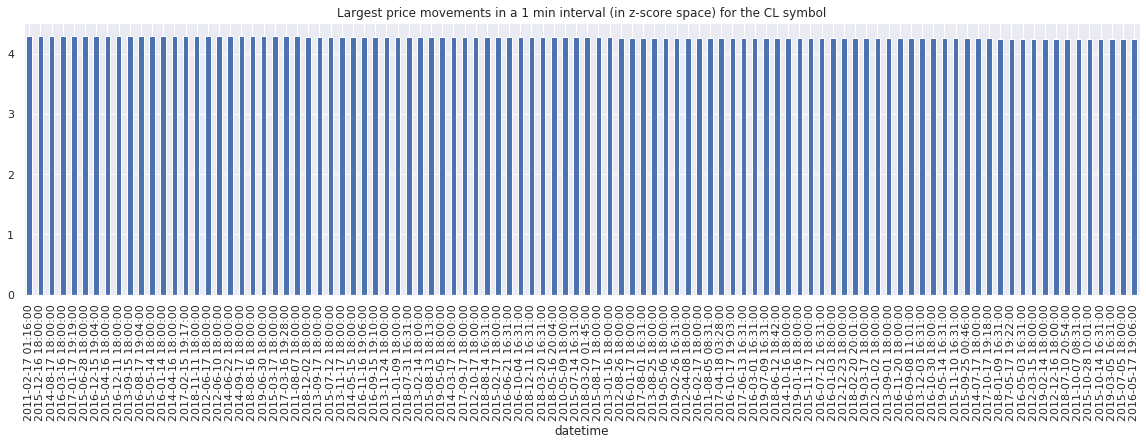

In [16]:
top_1min_movements.plot(kind="bar")
plt.title(
    f"Largest price movements in a 1 min interval (in z-score space) for the {SYMBOL} symbol"
)
plt.show()

In [17]:
top_1min_movements_by_year = zscored_1min_rets.resample('Y').apply(get_top_100)
top_1min_movements_by_year.head()

datetime    datetime           
2009-12-31  2009-12-08 16:31:00    4.201319
            2009-11-22 18:00:00    4.163986
            2009-11-17 16:30:00    4.156503
            2009-11-18 12:57:00    4.154908
            2009-12-16 10:31:00    4.154353
Name: ret_0, dtype: float64

# 5-min movements

In [18]:
zscored_5min_rets = pma.get_zscored_returns(
    five_min_prices, "minutely"
)
top_5min_movements = get_top_100(zscored_5min_rets)

In [19]:
top_5min_movements.head()

datetime
2011-02-17 01:15:00    4.292089
2017-06-07 10:30:00    4.266978
2018-03-20 01:45:00    4.250278
2009-12-04 08:30:00    4.227688
2017-04-26 10:30:00    4.211947
Name: ret_0, dtype: float64

In [20]:
print(f"Top 100 of the 5-min price movements for {SYMBOL} occur at the following time:")
print(pd.Series(top_5min_movements.index).dt.time.value_counts())

Top 100 of the 5-min price movements for CL occur at the following time:
10:30:00    20
16:30:00    13
08:30:00     8
03:25:00     2
11:00:00     2
13:50:00     2
03:05:00     2
03:30:00     2
04:25:00     2
09:00:00     2
03:00:00     1
09:50:00     1
23:25:00     1
10:45:00     1
05:40:00     1
08:00:00     1
05:55:00     1
09:10:00     1
07:25:00     1
01:05:00     1
11:25:00     1
05:45:00     1
11:50:00     1
10:15:00     1
07:45:00     1
07:55:00     1
05:30:00     1
07:20:00     1
08:10:00     1
04:10:00     1
02:30:00     1
00:20:00     1
02:45:00     1
02:15:00     1
21:50:00     1
09:05:00     1
07:40:00     1
10:35:00     1
01:15:00     1
22:40:00     1
04:00:00     1
03:45:00     1
03:15:00     1
00:55:00     1
09:20:00     1
21:20:00     1
00:40:00     1
23:35:00     1
01:45:00     1
00:30:00     1
05:00:00     1
09:35:00     1
01:00:00     1
22:15:00     1
05:10:00     1
Name: datetime, dtype: int64


In [21]:
top_5min_movements_by_year = zscored_5min_rets.resample('Y').apply(get_top_100)
top_5min_movements_by_year.head()

datetime    datetime           
2009-12-31  2009-12-04 08:30:00    4.227688
            2009-12-16 10:30:00    4.026082
            2009-10-02 08:30:00    3.995286
            2009-10-21 10:30:00    3.899341
            2009-12-29 06:55:00    3.892555
Name: ret_0, dtype: float64

In [22]:
top_5min_movements_by_year.tail()

datetime    datetime           
2019-12-31  2019-01-28 00:30:00    3.387837
            2019-03-06 10:00:00    3.387275
            2019-01-04 00:30:00    3.386467
            2019-01-04 08:25:00    3.384488
            2019-06-11 16:30:00    3.384389
Name: ret_0, dtype: float64